# 1. Título - Análise de dados referentes a poços de extração de petróleo e gás natural

# 2. Membros

| Aluno  | Matrícula |
| --- |  :---: |
|  Arthur de Oliveira Lima | 2019027318 |
| Camila Santana Braz | 2019027423 |
| Leandro Guatimosim Gripp | 2020027822 |
| Vinícius Fernandes Lara | 2019101143 |



# 3. Descrição e tratamento dos dados

A base de dados escolhida foi a de produção de petróleo e gás natural por poço, disponibilizada pela Agência nacional do Petróleo, Gás Natural e Biocombustíveis (ANP). O dataset foi atualizado pela última vez em março de 2023 e está dispoível [neste endereço](https://dados.gov.br/dados/conjuntos-dados/producao-de-petroleo-e-gas-natural-por-poco).

O descritivo de dados fornecido pela ANP é apresentado abaixo, e em seguida é demonstrado o processo de tratamento dos dados para que ele tome a forma apresentada nas seções 4 e 5.

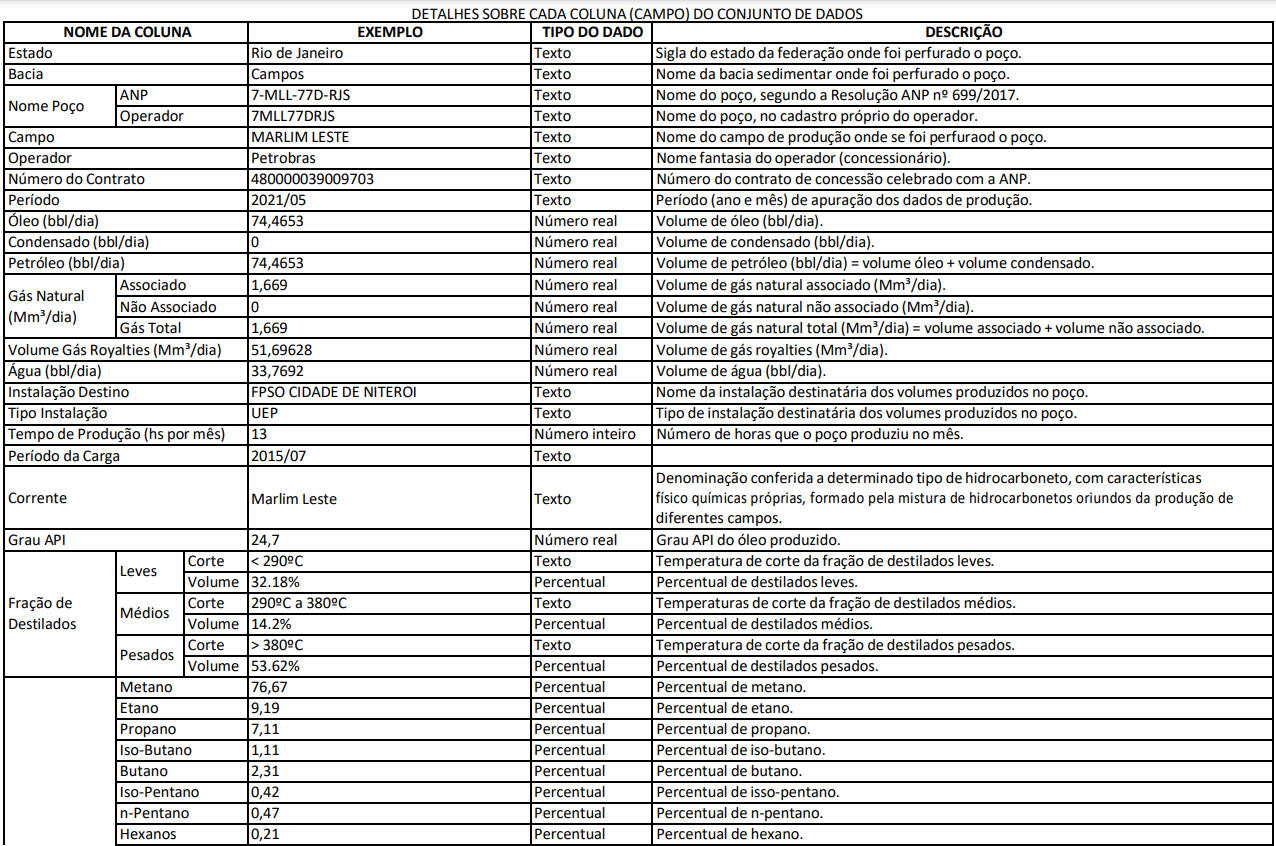

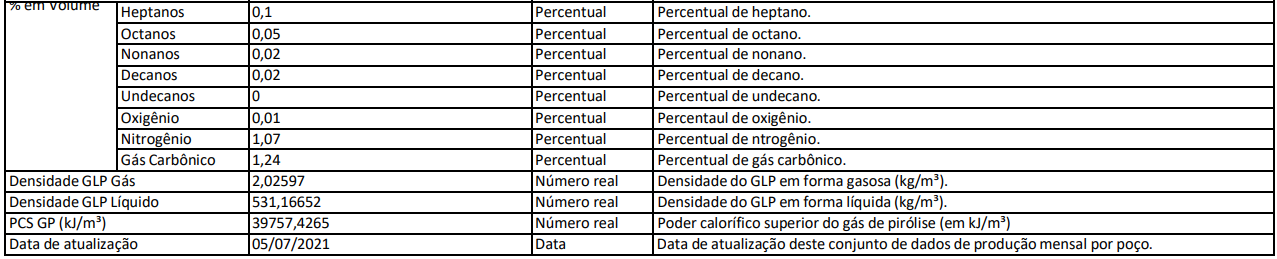


## Inicialização e importações

In [2]:
import pandas as pd
import io
import os
import requests
import urllib.request
import sqlite3

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

In [4]:
subset = True

## 3.1. Buscando o conjunto completo de dados

* Conectando com o banco de dados (objeto `conn`)
* Configurando o banco de dados com as tabelas descritas no arquivo `db.sql`
* Importando datasets do repositório
* Criando `OriginalDataSet` com o conjunto completo de dados


In [11]:
# Reading DB definition file

conn = sqlite3.connect('./tmp/consult.db')
cursor = conn.cursor()

db_file_url = "https://raw.githubusercontent.com/camilasbraz/analise-bd-producao-poco/main/db.sql"

urllib.request.urlretrieve(db_file_url, "./tmp/db.sql")

('./tmp/db.sql', <http.client.HTTPMessage at 0x1be59b3b670>)

In [13]:
f = io.open("./tmp/db.sql", 'r', encoding='utf-8')
sql = f.read()
cursor.executescript(sql)

In [ ]:
# Getting all the file URLs from github
url = "https://api.github.com/repos/camilabraz/analise-bd-producao-poco/git/trees/main?recursive=1"
r = requests.get(url)
res = r.json()

ds_files = [file["path"][5:] for file in res["tree"] if file["path"].startswith("data/")]

In [ ]:
# Read one file
base_url = "https://raw.githubusercontent.com/LeandroGripp/ibd_tp2_analise_pocos/master/data"

def read_ds_to_df(file_name):
  ano = int(file_name[:-4].split("_")[0])
  mes = int(file_name[:-4].split("_")[1])
  area = file_name[:-4].split("_")[3]

  skip = 7 if mes<9 else 3

  file_path = f"{base_url}/{file_name}"
  urllib.request.urlretrieve(file_path, f"/tmp/{file_name}")

  df = pd.read_csv('/'.join(('/tmp', file_name)), sep=';', header=None, skiprows=skip, thousands=',', decimal=',')
  df = df if mes<9 else df.drop(47,axis='columns')
  df.columns = [
      "estado", "bacia", "nome_poco_anp", "nome_poco_operador", "campo", "operador", "numero_contrato", "periodo", "oleo", "condensado", "petroleo",
      "gas_natural_associado", "gas_natural_nao_associado", "gas_natural_total", "volume_gas_royalties", "agua", "instalacao_destino", "tipo_instalacao",
      "tempo_producao", "periodo_da_carga", "corrente", "grau_api", "fp_lc", "fp_lv", "fp_mc", "fp_mv", "fp_pc", "fp_pv",
      "metano", "etano", "propano", "isobutano", "butano", "isopentano", "npentano", "hexanos", "heptanos", "octanos", "nonanos", "decanos",
      "undecanos", "oxigenio", "nitrogenio", "gas_carbonico", "densidade_glp_gas", "densidade_glp_liquido", "pcs_gp"
  ]
  # df["ano"] = file_name[:-4].split("_")[0]
  # df["mes"] = file_name[:-4].split("_")[1]
  # df["area"] = file_name[:-4].split("_")[3]

  return df

In [ ]:


if subset:
  df_data = read_ds_to_df(ds_files[0])
  df_data.to_sql(name='FullData', con=conn, if_exists='append', index=False)
else:
  for i in range(len(ds_files)):
    df_data = read_ds_to_df(ds_files[i])
    df_data.to_sql(name='FullData', con=conn, if_exists='append', index=False)

## 3.2. Construindo as tabelas a partir do conjunto completo de dados
Nessa etapa, foram construídas as tabelas normalizadas a partir da tabela redundante original. Em todas as tabelas, foi introduzido um ID incremental para garantia de eliminação de possíveis ambiguidades que poderiam vir a surgir no futuro.

Nessa etapa, primeiramente foram definidas as entidades `Campos` e `Operadores`, que puderam ser definidas ao extrair as entradas únicas contendo os seus atributos do conjunto completo de dados.

Em seguida, foi definida a entidade `Concessões`, que relaciona um `Campo` a um `Operador` por meio de um número de contrato. Para isso, foram utilizados os nomes dos campos e dos operadores, para nessa nova tabela associar os IDs dos campos e dos operadores ao número de contrato.

Em seguida, foram definidas as entidades `Poço` e `Instalação`, por meio de um processo semelhante ao utilizado para definir `Campos` e `Operadores`. Contudo, a entidade `Poço` conta com uma coluna `id_operador`, pois poço tem participação obrigatória no relacionamento `Responsabilidade` do diagrama ER e cada poço tem um único operador responsável.

Finalmente, é definida a entidade `Produção`, que relaciona um `Poço`, um `Campo` e, potencialmente, uma `Instalação`, associando a esses elementos os dados de produção dos diferentes materiais.

### 3.2.1. Campos

In [ ]:
conn.execute('DELETE FROM Campos;')

cmd = """
INSERT INTO
  Campos(nome_campo, estado, bacia)
SELECT DISTINCT
  campo as nome_campo, estado, bacia
FROM
  FullData
"""

conn.execute(cmd)

In [ ]:
query = """
SELECT *
FROM
  Campos
"""

df = pd.read_sql_query(query, conn)
df

,id_campo,nome_campo,estado,bacia
0,1,ITAPU,Rio de Janeiro,Santos
1,2,ATAPU,Rio de Janeiro,Santos
2,3,VIOLA,Rio de Janeiro,Campos
3,4,SAPINHOÁ,São Paulo,Santos
4,5,BAÚNA,São Paulo,Santos
...,...,...,...,...
95,96,TARTARUGA,Sergipe,Sergipe
96,97,URUGUÁ,Rio de Janeiro,Santos
97,98,XARÉU,Ceará,Ceará
98,99,SURURU,Rio de Janeiro,Santos


### 3.2.2. Operadores




In [ ]:
conn.execute('DELETE FROM Operadores;')

cmd = """
INSERT INTO
  Operadores(nome_operador)
SELECT DISTINCT
  operador as nome_operador
FROM
  FullData
"""

conn.execute(cmd)

In [ ]:
query = """
SELECT *
FROM
  Operadores
"""

df = pd.read_sql_query(query, conn)
df

,id_operador,nome_operador
0,1,Petrobras
1,2,Total E&P do Brasil
2,3,Shell Brasil
3,4,Enauta Energia S.A.
4,5,Petro Rio Jaguar
5,6,Perenco Brasil
6,7,Petro Rio O&G
7,8,Equinor Brasil
8,9,Dommo Energia
9,10,Maha Energy


### 3.2.3. Concessões




In [ ]:
conn.execute('DELETE FROM Concessoes;')

cmd = """
INSERT INTO
  Concessoes(numero_contrato, id_operador, id_campo)
SELECT DISTINCT
  F.numero_contrato, O.id_operador, C.id_campo
FROM
  FullData as F
INNER JOIN
  Operadores as O
ON
  F.operador = O.nome_operador
INNER JOIN
  Campos as C
ON
  F.campo = C.nome_campo
"""

conn.execute(cmd)

In [ ]:
query = """
SELECT *
FROM
  Concessoes
"""

df = pd.read_sql_query(query, conn)
df

,id_concessao,numero_contrato,id_operador,id_campo
0,1,48610012913201000,1,1
1,2,48610012913201000,1,2
2,3,480000037349728,1,3
3,4,486100038842000,1,4
4,5,486100094942003,1,5
...,...,...,...,...
109,110,480000038359735,10,96
110,111,480000035779741,1,97
111,112,480000037789701,1,98
112,113,486100038862000,1,99


### 3.2.4. Poços

In [ ]:
conn.execute('DELETE FROM Pocos;')

cmd = """
INSERT INTO
  Pocos(nome_poco_anp, nome_poco_operador, id_operador)
SELECT DISTINCT
  F.nome_poco_anp, F.nome_poco_operador, O.id_operador
FROM
  FullData as F
INNER JOIN
  Operadores as O
ON
  F.operador = O.nome_operador
"""

conn.execute(cmd)

In [ ]:
query = """
SELECT *
FROM
  Pocos
"""

df = pd.read_sql_query(query, conn)
df

,id_poco,nome_poco_anp,nome_poco_operador,id_operador
0,1,1-BRSA-1116-RJS,1RJS704,1
1,2,1-BRSA-1146-RJS,1RJS711,1
2,3,1-BRSA-319-RJS,1RJS620,1
3,4,1-BRSA-594-SPS,1SPS55,1
4,5,1-BRSA-607-SPS,1SPS56,1
...,...,...,...,...
1145,1146,9-RO-17D-RJS,9RO17DRJS,1
1146,1147,9-RO-82B-RJS,9RO82BRJS,1
1147,1148,9-SEP-1-RJS,9SEP1RJS,1
1148,1149,9-TBU-2HA-RJS,9TBU2HARJS,1


### 3.2.5. Instalações



In [ ]:
conn.execute('DELETE FROM Instalacoes;')

cmd = """
INSERT INTO
  Instalacoes(nome_instalacao, tipo_instalacao)
SELECT DISTINCT
  instalacao_destino as nome_instalacao, tipo_instalacao
FROM
  FullData
WHERE
  instalacao_destino IS NOT NULL;
"""

conn.execute(cmd)

In [ ]:
query = """
SELECT *
FROM
  Instalacoes

"""

df = pd.read_sql_query(query, conn)
df

,id_instalacao,nome_instalacao,tipo_instalacao
0,1,FPSO CIDADE DE ITAJAÍ,UEP
1,2,PEROA,UEP
2,3,PETROBRAS 43,UEP
3,4,PLATAFORMA DE ARATUM 1,UEP
4,5,PLATAFORMA OESTE DE UBARANA 1,UEP
...,...,...,...
103,104,PLATAFORMA DE XAREU 1,UEP
104,105,PLATAFORMA DE XAREU 2,UEP
105,106,PLATAFORMA DE XAREU 3,UEP
106,107,PLATAFORMA DE ATUM 3,UEP


### 3.2.6. Produções

In [ ]:
conn.execute('DELETE FROM Producoes;')

cmd = """
INSERT INTO
  Producoes(
    periodo,
    oleo,
    condensado,
    petroleo,
    gas_natural_associado,
    gas_natural_nao_associado,
    gas_natural_total,
    volume_gas_royalties,
    agua,
    tempo_producao,
    periodo_da_carga,
    corrente,
    grau_api,
    fp_lc,
    fp_lv,
    fp_mc,
    fp_mv,
    fp_pc,
    fp_pv,
    metano,
    etano,
    propano,
    isobutano,
    butano,
    isopentano,
    npentano,
    hexanos,
    heptanos,
    octanos,
    nonanos,
    decanos,
    undecanos,
    oxigenio,
    nitrogenio,
    gas_carbonico,
    densidade_glp_gas,
    densidade_glp_liquido,
    pcs_gp,
    instalacao_destino,
    id_poco,
    id_campo
  )
SELECT
  F.periodo,
  F.oleo,
  F.condensado,
  F.petroleo,
  F.gas_natural_associado,
  F.gas_natural_nao_associado,
  F.gas_natural_total,
  F.volume_gas_royalties,
  F.agua,
  F.tempo_producao,
  F.periodo_da_carga,
  F.corrente,
  F.grau_api,
  F.fp_lc,
  F.fp_lv,
  F.fp_mc,
  F.fp_mv,
  F.fp_pc,
  F.fp_pv,
  F.metano,
  F.etano,
  F.propano,
  F.isobutano,
  F.butano,
  F.isopentano,
  F.npentano,
  F.hexanos,
  F.heptanos,
  F.octanos,
  F.nonanos,
  F.decanos,
  F.undecanos,
  F.oxigenio,
  F.nitrogenio,
  F.gas_carbonico,
  F.densidade_glp_gas,
  F.densidade_glp_liquido,
  F.pcs_gp,
  I.id_instalacao as instalacao_destino,
  P.id_poco,
  C.id_campo
FROM
  FullData as F
INNER JOIN
  Campos as C
ON
  F.campo = C.nome_campo
INNER JOIN
  Pocos as P
ON
  F.nome_poco_anp = P.nome_poco_anp
LEFT JOIN
  Instalacoes as I
ON
  F.instalacao_destino = I.nome_instalacao
"""

conn.execute(cmd)

In [ ]:
query = """
SELECT
  *
FROM
  Producoes
"""

df = pd.read_sql_query(query, conn)
df

,id_producao,periodo,oleo,condensado,petroleo,gas_natural_associado,gas_natural_nao_associado,gas_natural_total,volume_gas_royalties,agua,tempo_producao,periodo_da_carga,corrente,grau_api,fp_lc,fp_lv,fp_mc,fp_mv,fp_pc,fp_pv,metano,etano,propano,isobutano,butano,isopentano,npentano,hexanos,heptanos,octanos,nonanos,decanos,undecanos,oxigenio,nitrogenio,gas_carbonico,densidade_glp_gas,densidade_glp_liquido,pcs_gp,instalacao_destino,id_poco,id_campo
0,1,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2015/07,Área de Florim,293.0,< 270ºC,"34,45%",270ºC a 458ºC,"28,01%",> 458ºC,"37,54%",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,2,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2015/07,Entorno de Iara,277.0,< 270ºC,"30,30%",270ºC a 458ºC,"26,60%",> 458ºC,"43,10%",52075.0,812.0,5067.0,817.0,1731.0,448.0,597.0,384.0,237.0,109.0,2.0,0.0,0.0,0.0,451.0,29945.0,2032831.0,531967518.0,276712836.0,NaN,2,2
2,3,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2017/02,Cabiúnas Mistura,25.0,< 290ºC,"32,76%",290ºC a 380ºC,"14,58%",> 380ºC,"52,66%",8127.0,818.0,533.0,93.0,163.0,24.0,32.0,13.0,7.0,3.0,1.0,0.0,0.0,0.0,66.0,12.0,2025574.0,53112293.0,395424899.0,NaN,3,3
3,4,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2018/11,Sapinhoá,301.0,< 270ºC,"34,10%",270ºC a 458ºC,"27,91%",> 458ºC,"37,99%",7040757.0,114576.0,916978.0,131006.0,228984.0,37572.0,39816.0,7168.0,1421.0,54.0,15.0,0.0,0.0,0.0,105059.0,344789.0,2000271.0,528090035.0,396202435.0,NaN,4,4
4,5,2020/01,"2.414,4819","0,0000","2.414,4819","18,9663","0,0000","18,9663","518,00922","3.061,9787",739,2015/07,Baúna,333.0,< 270ºC,"38,68%",270ºC a 458ºC,"31,02%",> 458ºC,"30,30%",7026.0,658.0,1112.0,302.0,461.0,112.0,115.0,17.0,3.0,0.0,0.0,0.0,0.0,0.0,164.0,3.0,2074121.0,536948648.0,393008661.0,1.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,1416,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2015/07,Roncador,228.0,< 290ºC,"26,50%",290ºC a 380ºC,"14,88%",> 380ºC,"58,62%",861317.0,54501.0,30959.0,5743.0,11373.0,2846.0,3701.0,2853.0,2363.0,122.0,692.0,395.0,0.0,41.0,5146.0,1685.0,204591.0,53352716.0,385050697.0,NaN,1146,30
1416,1417,2020/01,"3.103,2038","0,0000","3.103,2038","24,6956","0,0000","24,6956","764,78693","156,9462",744,2015/07,Roncador,228.0,< 290ºC,"26,50%",290ºC a 380ºC,"14,88%",> 380ºC,"58,62%",861317.0,54501.0,30959.0,5743.0,11373.0,2846.0,3701.0,2853.0,2363.0,122.0,692.0,395.0,0.0,41.0,5146.0,1685.0,204591.0,53352716.0,385050697.0,11.0,1147,30
1417,1418,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2015/07,Área de Nordeste de Tupi,262.0,< 290ºC,"32,07%",290ºC a 380ºC,"12,18%",> 380ºC,"55,75%",5489914.0,873416.0,55776.0,93164.0,20153.0,52207.0,71.0,51707.0,43431.0,3106.0,667.0,0.0,0.0,0.0,60417.0,2467724.0,203995.0,532809662.0,298515187.0,NaN,1148,6
1418,1419,2020/01,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,00000","0,0000",0,2015/07,Tambaú-Uruguá,326.0,< 270ºC,"34,18%",270ºC a 458ºC,"35,72%",> 458ºC,"30,10%",95132.0,2329.0,732.0,163.0,24.0,97.0,113.0,138.0,169.0,141.0,62.0,0.0,0.0,0.0,673.0,11.0,2048628.0,533784881.0,381248811.0,NaN,1149,93


# 4. Diagrama ER
A seguir, é apresentado o diagrama ER proposto para a modelagem dos dados. Os campos de `Produção` são, em sua maioria, omitidos, pois são muito numerosos para o diagrama.

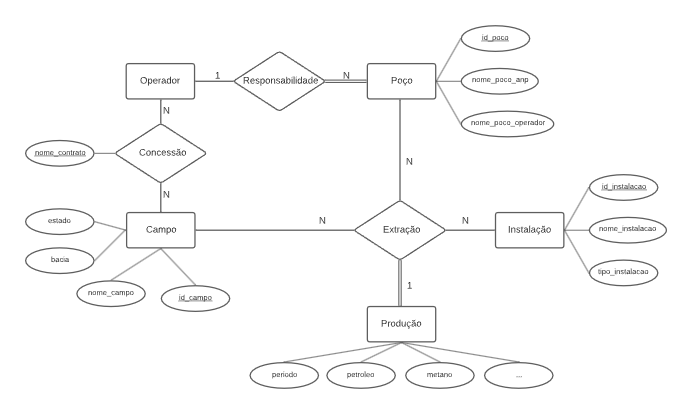

# 5. Diagrama relacional
Abaixo é apresentado o diagrama relacional desenvolvido. A maior parte das colunas de `Produções` é omitida para fins de brevidade. São apresentadas todas as colunas que têm restrições de chave. Pode-se ver todas as colunas listadas na seção 5.1

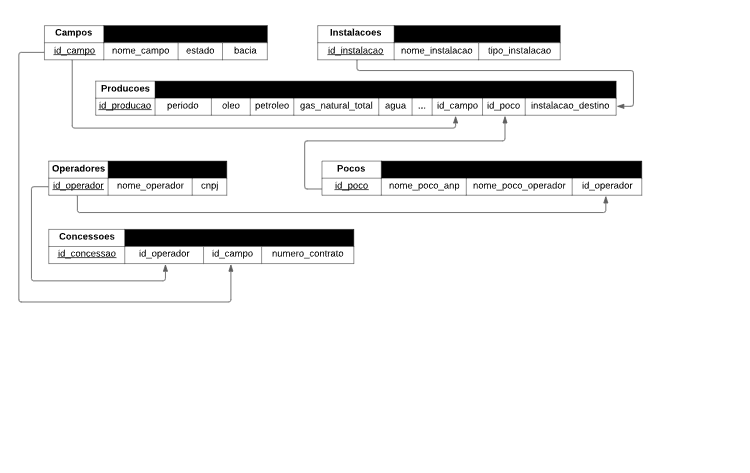


## 5.1. Expansão de todas as colunas de `Produções`

* id_producao
* periodo
* oleo
* condensado
* petroleo
* gas_natural_associado
* gas_natural_nao_associado
* gas_natural_total
* volume_gas_royalties
* agua
* tempo_producao
* periodo_da_carga
* corrente
* grau_api
* fp_lc
* fp_lv
* fp_mc
* fp_mv
* fp_pc
* fp_pv
* metano
* etano
* propano
* isobutano
* butano
* isopentano
* npentano
* hexanos
* heptanos
* octanos
* nonanos
* decanos
* undecanos
* oxigenio
* nitrogenio
* gas_carbonico
* densidade_glp_gas
* densidade_glp_liquido
* pcs_gp
* instalacao_destino
* id_poco
* id_campo

# 6. Consultas

## 6.1. Duas consultas envolvendo seleção e projeção

### 6.1.1. Consulta 1
Seleção de todos os campos que estão em São Paulo.

In [ ]:
query = """
SELECT nome_campo
FROM
  Campos
WHERE
  estado = "São Paulo"
"""

df = pd.read_sql_query(query, conn)
df

,nome_campo
0,SAPINHOÁ
1,BAÚNA
2,SUDOESTE DE SAPINHOÁ
3,NOROESTE DE SAPINHOA
4,NORDESTE DE SAPINHOÁ
5,LAPA
6,LAGOSTA
7,MERLUZA
8,MEXILHÃO


### 6.1.2. Consulta 2
Seleção de todas as produções que produziram petróleo, com as suas respectivas quantidades de petróleo. Nesse caso, como se trata de um número real, foi necessário estabelecer uma tolerância. Isso significa que a query retornará as informações relacionadas às produções que possuem um valor de petróleo maior ou igual a 0.1

In [ ]:
query = """
SELECT id_producao, id_campo, id_poco, instalacao_destino, petroleo
FROM
  Producoes
WHERE
  (petroleo - 0.1) >= 0
"""

df = pd.read_sql_query(query, conn)
df

,id_producao,id_campo,id_poco,instalacao_destino,petroleo
0,5,5,5,1,"2.414,4819"
1,7,7,7,2,"98,9890"
2,13,12,13,3,"1.104,2610"
3,20,16,20,4,"46,2102"
4,22,17,22,5,"198,4601"
...,...,...,...,...,...
903,1410,43,1141,75,"3.001,0312"
904,1411,14,1141,75,"56,2541"
905,1413,84,1143,77,"426,4416"
906,1415,92,1145,88,"1.923,4163"


## 6.2. Três consultas envolvendo junção de duas relações

### 6.2.1. Consulta 3
Seleção de todos os estados que produzem gás natural.

In [ ]:
query = """
SELECT DISTINCT C.estado,
FROM
  Campos as C INNER JOIN Producoes as P
ON
  C.id_campo = P.id_campo
WHERE
  (gas_natural_total - 0.1) >= 0
"""

df = pd.read_sql_query(query, conn)
df

,estado
0,São Paulo
1,Espírito Santo
2,Rio de Janeiro
3,Rio Grande do Norte
4,Sergipe
5,Ceará
6,Bahia


### 6.2.2. Consulta 4
Seleção de todos os poços que são operados pela Shell Brasil

In [ ]:
query = """
SELECT DISTINCT P.id_poco, P.nome_poco_anp
FROM
  Pocos as P INNER JOIN Operadores as O
ON
  P.id_operador = O.id_operador
WHERE
  O.nome_operador = 'Shell Brasil'
"""

df = pd.read_sql_query(query, conn)
df


,id_poco,nome_poco_anp
0,180,7-ABA-2D-ESS
1,209,7-ARGO-10H-ESS
2,210,7-ARGO-13H-ESS
3,211,7-ARGO-14H-ESS
4,212,7-ARGO-17H-ESS
...,...,...
35,927,7-SA-3HPA-RJS
36,928,7-SA-5HP-RJS
37,929,7-SA-7HP-RJS
38,930,7-SA-8H-RJS


### 6.2.3. Consulta 5
Seleção de todas as produções que têm especificada uma instalação e que essa instalação é de tipo INSTALACAO EMB/DESEMB.

In [ ]:
query = """
SELECT DISTINCT P.id_producao, P.id_campo, P.id_poco, I.id_instalacao, I.nome_instalacao
FROM
  Producoes as P INNER JOIN Instalacoes as I
ON
  P.instalacao_destino = I.id_instalacao
WHERE
  tipo_instalacao = 'INSTALACAO EMB/DESEMB'
"""

df = pd.read_sql_query(query, conn)
df

,id_producao,id_campo,id_poco,id_instalacao,nome_instalacao
0,358,67,305,50,Estação Pedra Branca
1,485,75,431,61,Estação Marapé (Dom João Mar)
2,486,76,431,61,Estação Marapé (Dom João Mar)
3,487,75,432,61,Estação Marapé (Dom João Mar)
4,488,76,432,61,Estação Marapé (Dom João Mar)
...,...,...,...,...,...
81,1164,81,957,70,Estação Coletora de Macau
82,1226,96,979,90,Ponto de Coleta de Tartaruga
83,1227,96,980,90,Ponto de Coleta de Tartaruga
84,1346,75,1098,61,Estação Marapé (Dom João Mar)


## 6.3. Três consultas envolvendo junção de três ou mais relações

### 6.3.1. Consulta 6
Seleção de todos os estados em que a Petrobras realiza produções ou seja, possui concessão para operar os campos.

In [ ]:
query = """
SELECT DISTINCT C.estado
FROM
  Campos as C INNER JOIN Concessoes as Co
    ON
      C.id_campo = Co.id_campo
  INNER JOIN Operadores as O
    ON
      Co.id_operador = O.id_operador
WHERE
  O.nome_operador = 'Petrobras'
"""

df = pd.read_sql_query(query, conn)
df

,estado
0,Rio de Janeiro
1,São Paulo
2,Espírito Santo
3,Rio Grande do Norte
4,Sergipe
5,Ceará
6,Alagoas
7,Bahia


### 6.3.2. Consulta 7
Seleção de todas as produções que ocorrem em poços operados pela Equinor Brasil

In [ ]:
query = """
SELECT DISTINCT P.id_producao, P.id_campo, P.id_poco, P.instalacao_destino
FROM
  Producoes as P INNER JOIN Pocos as Po
    ON
      P.id_poco = Po.id_poco
  INNER JOIN Operadores as O
    ON
      Po.id_operador = O.id_operador
WHERE
  O.nome_operador = 'Equinor Brasil'
"""

df = pd.read_sql_query(query, conn)
df

,id_producao,id_campo,id_poco,instalacao_destino
0,992,90,833,83
1,993,90,834,84
2,994,90,835,83
3,995,90,836,84
4,996,90,837,84
...,...,...,...,...
31,1023,90,864,84
32,1024,90,865,84
33,1025,90,866,83
34,1026,90,867,83


### 6.3.3. Consulta 8
Seleção de todas as instalações relacionadas a produções que ocorrem em campos que estão no estado da Bahia

In [ ]:
query = """
SELECT DISTINCT I.id_instalacao, I.nome_instalacao, I.tipo_instalacao
FROM
  Producoes as P INNER JOIN Campos as C
    ON
      P.id_campo = C.id_campo
  LEFT OUTER JOIN Instalacoes as I
    ON
      P.instalacao_destino = I.id_instalacao
WHERE
  C.estado = 'Bahia' AND I.id_instalacao IS NOT NULL
"""

df = pd.read_sql_query(query, conn)
df

,id_instalacao,nome_instalacao,tipo_instalacao
0,50,Estação Pedra Branca,INSTALACAO EMB/DESEMB
1,61,Estação Marapé (Dom João Mar),INSTALACAO EMB/DESEMB
2,73,PLATAFORMA DE MANATI 1,UEP


## 6.4. Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1. Consulta 9
Informações de número de produções e volume total (soma de todas as produções) de petróleo produzido agrupadas por operador. Os resultados são ordenados pela produção total de petróleo em ordem decrescente

In [ ]:
query = """
SELECT O.id_operador, O.nome_operador, SUM(P.petroleo) as prod_total_petroleo, COUNT(*) as num_producoes
FROM
  Operadores as O INNER JOIN Pocos as Po
    ON
      O.id_operador = Po.id_operador
  INNER JOIN Producoes as P
    ON
      Po.id_poco = P.id_poco
GROUP BY O.id_operador
ORDER BY prod_total_petroleo DESC
"""

df = pd.read_sql_query(query, conn)
df

,id_operador,nome_operador,prod_total_petroleo,num_producoes
0,1,Petrobras,84429.193,1295
1,3,Shell Brasil,6385.126,40
2,7,Petro Rio O&G,5409.876,17
3,8,Equinor Brasil,4144.394,36
4,5,Petro Rio Jaguar,2530.459,11
5,6,Perenco Brasil,1117.000,7
6,10,Maha Energy,471.000,2
7,4,Enauta Energia S.A.,30.676,3
8,2,Total E&P do Brasil,29.346,4
9,9,Dommo Energia,5.749,5


### 6.4.2. Consulta 10
Informações de produção média de gás natural e o número total de produções de cada agrupadas por poço com uma filtragem a posteriori de produção média de gás natural maior que 300. Os resultados são ordenados pela produção média de gás natural em ordem decrescente.


In [ ]:
query = """
SELECT Po.id_poco, Po.nome_poco_anp, AVG(P.gas_natural_total) AS prod_media_gas_natural, COUNT(*) AS num_producoes
FROM
  Pocos as Po INNER JOIN Producoes as P
    ON Po.id_poco = P.id_poco
GROUP BY Po.id_poco
HAVING prod_media_gas_natural > 300
ORDER BY prod_media_gas_natural DESC
"""

df = pd.read_sql_query(query, conn)
df

,id_poco,nome_poco_anp,prod_media_gas_natural,num_producoes
0,52,3-BRSA-830-RJS,828.000000,1
1,895,7-RO-154D-RJS,810.000000,1
2,547,7-LL-31D-RJS,808.000000,1
3,53,3-BRSA-839A-RJS,806.000000,1
4,665,7-MNT-6D-BAS,792.000000,1
...,...,...,...,...
44,44,3-BRSA-496-RJS,321.666667,3
45,570,7-LL-84D-RJS,314.666667,3
46,1105,8-LL-87D-RJS,311.666667,3
47,559,7-LL-61-RJS,311.333333,3


# 7. Autoavaliação dos membros

## 7.1. Arthur de Oliveira Lima

Fui responsável pela estruturação, modelagem e criação do banco de dados a partir do conjunto de dados selecionado. Partindo da compreensão da base de dados e suas propriedades, realizei a modelagem do DB e, posteriormente, a quebra e inserção dos dados vindos dos .csv nas respectivas tabelas. Boa parte do trabalho foi relacionada ao melhor entendimento dos dados, modelagem em diagrama ER, transposição para tabelas e operações SQL com o conjunto bruto de dados para adequar ao modelo planejado.

Considero ter feito um trabalho satisfatório, uma vez que as demais tarefas do trabalho lançam mão do estruturação realizada nesta etapa.

## 7.2. Camila Santana Braz
Considero ter realizado um trabalho satisfatório.

Na primeira entrega, contribui com a seleção da fonte de dados e com sua modelagem nos parâmetros do trabalho, além de ter sido responsável pela criação do relatório de entrega, escrevendo grande parte do documento.

Na segunda entrega, contribui com ideias de consultas a serem implementadas, conferi as consultas e as modelagens e melhorei suas descrições em alto nível. Além disso, fui responsável por produzir os slides da apresentação e organizá-la.

## 7.3. Leandro Guatimosim Gripp
Considero ter realizado um trabalho satisfatório. Fui o responsável por realizar a estrutura básica do notebook e configurar o processo de buscar os arquivos remotamente no github, além de ter criado o repositório para gestão do projeto e ter estruturado o notebook usado para o trabalho, em suas diversas seções.

Além disso, fui responsável por grande parte do trabalho nas consultas, sobretudo as que precisaram de agregações.

## 7.4. Vinícius Fernandes Lara

Contribui com a seleção da fonte de dados, entendimento dos dados e análise dos requisitos do trabalho para que os dados cumprissem com o trabalho. Ademais contribui também com consultas sugeridas na primeira entrega. Na segunda parte do trabalho ajudei na modelagem do diagrama ER, realizei a revisão das queries para que essas cumprissem com os requisitos do trabalho e fui responsável pelo desenvolvimento da aplicação do Streamlit. Dessa forma considero que realizei um trabalho satisfatório.